In [6]:
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from textblob import TextBlob
import advertools
import re
import spacy
import xgboost
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report,auc, 
                            roc_auc_score, precision_score,
                            recall_score,f1_score, accuracy_score)
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
# import contextualSpellCheck
import nltk
import nltk.util
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings("ignore")
nltk.download("wordnet")
nltk.download("stopwords")

[nltk_data] Downloading package wordnet to C:\Users\Ali
[nltk_data]     Haider\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Ali
[nltk_data]     Haider\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
data_path = Path.cwd().parent/"Data"
final_data = pd.read_csv("control_data.csv")
final_data.rename(columns={"Disorder":"class"}, inplace=True)

In [3]:
pipeline_data = final_data.copy()

# Data Preprocessing

In [5]:
def clean_text(text:str) -> str:
    tokens = advertools.word_tokenize(text,phrase_len=1)
    emoji_token = advertools.extract_emoji(tokens[0])
    emoji_token = emoji_token["emoji_text"]
    for tok in range(0,len(emoji_token)):
        if emoji_token[tok]:
            tokens[0][tok] = " ".join(emoji_token[tok])
    clean_text = " ".join(tokens[0])
    clean_pattern = r"@\w+|#\w+|\W+|x+|https\.\//www\.(\w+|\W+)\.com|http\w*|www\.(\w+|\W+)\.com|user\w*|\d+"
    clean_text = re.sub(clean_pattern," ",clean_text).strip()
    clean_text = re.sub(r"\s+"," ",clean_text).strip()
    return clean_text

In [6]:
def text_lemmatize(text: str) -> str:
    lemma = WordNetLemmatizer()
    tokens = advertools.word_tokenize(text,phrase_len=1)
    text = [lemma.lemmatize(tok) for tok in tokens[0]]
    return " ".join(text)

In [7]:
def spell_check(text:str) -> str:
    nlp = spacy.load("en_core_web_sm")
    nlp.add_pipe("contextual spellchecker")
    doc = nlp(text)
    return doc._.outcome_spellCheck

In [8]:
def remove_stopword(text: str) -> str:
    tokens = advertools.word_tokenize(text,phrase_len=1)[0]
    stop_words = stopwords.words("english")
    clean_word = [tok for tok in tokens if tok not in stop_words]
    return " ".join(clean_word)

# Vectorization

In [9]:
def generate_n_grams(text: str, n: list[int]) -> list[tuple]:
    tokens = advertools.word_tokenize(text,phrase_len=1)[0]
    if len(n)<=1:
        n_grams = list(nltk.ngrams(tokens,n[0],pad_right=True,right_pad_symbol="</s>"))
        bag_ngrams = " ".join(["_".join(c) for c in n_grams])
    else:
        bag_ngrams = " "
        for n_gram in range(n[0],n[1]+1):
            n_grams = list(nltk.ngrams(tokens,n_gram,pad_right=True,right_pad_symbol="</s>"))
            if n_gram==1:       
                n_grams = " ".join(["".join(c[0]) for c in n_grams])
                bag_ngrams+=n_grams
            else:
                n_grams = " ".join(["_".join(c) for c in n_grams])
                bag_ngrams+=" "+n_grams
    return bag_ngrams

In [10]:
def tfidf(train: pd.DataFrame, test:pd.DataFrame()):
    tf_idf = TfidfVectorizer()
    train_feat = tf_idf.fit_transform(train)
    test_feat = tf_idf.transform(test)
    return train_feat,test_feat

# ML Models

In [11]:
def classification_metrics(actuals: np.array, preds: np.array) -> pd.DataFrame:
    metrics_performance = pd.DataFrame()
    precision_0 = precision_score(actuals,preds, pos_label=0)
    precision_1 = precision_score(actuals,preds, pos_label=1)
    recall_0 = recall_score(actuals,preds,pos_label=0)
    recall_1 = recall_score(actuals,preds,pos_label=1)
    f1_0 = f1_score(actuals,preds,pos_label=0)
    f1_1 = f1_score(actuals,preds,pos_label=1)
    accuracy = accuracy_score(actuals,preds)
    metrics_performance["precision_0"] = [precision_0]
    metrics_performance["precision_1"] = [precision_1]
    metrics_performance["recall_0"] = [recall_0]
    metrics_performance["recall_1"] = [recall_1]
    metrics_performance["f1_0"] = [f1_0]
    metrics_performance["f1_1"] = [f1_1]
    metrics_performance["accuracy"] = [accuracy]
    return metrics_performance

In [12]:
def build_models(preprocessed_data: pd.DataFrame, 
                 label: str, 
                 weights: bool,
                 filename: str) -> pd.DataFrame:
    X = preprocessed_data[["text_features"]]
    y = preprocessed_data[[label]]
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,
                                                 stratify=y,random_state=42)
    metrics_performance = pd.DataFrame()
    train_data,test_data = tfidf(X_train["text_features"],X_test["text_features"])
    print("logistic regression started")
    log_reg = LogisticRegression(n_jobs=-1)
    log_reg.fit(train_data,y_train)
    y_pred = log_reg.predict(test_data)
    log_reg_perf = classification_metrics(np.squeeze(y_test.values),y_pred)
    log_reg_perf["models"] = "Logistic Regression"
    if weights:
        w_1 = len(X_train)/(2*y_train.value_counts()[1])
        w_0 = len(X_train)/(2*y_train.value_counts()[0])
        class_weights = {0:w_0,1:w_1}
        print("Weighted model initialized")
        rand_clf = RandomForestClassifier(n_jobs=-1,class_weight=class_weights)
        svm_clf_rbf = SVC(class_weight=class_weights)
        svm_clf_lr = SVC(class_weight=class_weights,kernel="linear")
        svm_clf_poly = SVC(class_weight=class_weights,kernel="poly",degree=3)
        dt_clf = DecisionTreeClassifier(class_weight=class_weights)
    else:
        print("Non-Weighted model initialized")
        rand_clf = RandomForestClassifier(n_jobs=-1)
        svm_clf_rbf = SVC()
        svm_clf_lr = SVC(kernel="linear")
        svm_clf_poly = SVC(kernel="poly",degree=3)
        dt_clf = DecisionTreeClassifier()
    print("Random Forest started")
    rand_clf.fit(train_data,y_train)
    y_pred = rand_clf.predict(test_data)
    rand_forest_perf = classification_metrics(np.squeeze(y_test.values),y_pred)
    rand_forest_perf["models"] = "Random Forest"
    xgb_clf = xgboost.XGBClassifier(learning_rate = 1, 
                                 n_estimators=100,
                                 max_depth=3,
                                 min_child_weight=1,
                                 gamma=0,
                                 subsample=1.0,
                                 reg_alpha = 0,
                                 reg_lambda = 1,
                                 objective= 'binary:logistic',
                                 booster = "gbtree")
    print("XGBOOST started")
    xgb_clf.fit(train_data,y_train)
    y_pred = xgb_clf.predict(test_data)
    xgb_perf = classification_metrics(np.squeeze(y_test.values),y_pred)
    xgb_perf["models"] = "XGBOOST"
    print("SVM rbf started")
    svm_clf_rbf.fit(train_data,y_train)
    y_pred = svm_clf_rbf.predict(test_data)
    svm_rbf_perf = classification_metrics(np.squeeze(y_test.values),y_pred)
    svm_rbf_perf["models"] = "SVM_rbf"
    print("SVM linear started")
    svm_clf_lr.fit(train_data,y_train)
    y_pred = svm_clf_lr.predict(test_data)
    svm_lr_perf = classification_metrics(np.squeeze(y_test.values),y_pred)
    svm_lr_perf["models"] = "SVM_linear"
    print("SVM poly started")
    svm_clf_poly.fit(train_data,y_train)
    y_pred = svm_clf_poly.predict(test_data)
    svm_poly_perf = classification_metrics(np.squeeze(y_test.values),y_pred)
    svm_poly_perf["models"] = "SVM_poly"
    print("Decision Tree started")
    dt_clf.fit(train_data,y_train)
    y_pred = dt_clf.predict(test_data)
    dt_clf_perf = classification_metrics(np.squeeze(y_test.values),y_pred)
    dt_clf_perf["models"] = "Decision Tree"
    performance_table = pd.concat([log_reg_perf,rand_forest_perf,
                                   xgb_perf,svm_rbf_perf,svm_lr_perf,
                                  svm_poly_perf,dt_clf_perf],axis=0)
    performance_table.to_csv(filename,index=False)
    return performance_table

## EDA

In [13]:
final_data["class"].unique()

array(['SCHIZOPHRENIA', 'ADHD', 'CONTROL', 'PTSD', 'OCD', 'DEPRESSION',
       'BIPOLAR', 'ANXIETY', 'EATING DISORDER', 'AUTISM'], dtype=object)

In [14]:
final_data = final_data[~(final_data["tweet"].isnull())]
final_data.isnull().sum()

class    0
tweet    0
dtype: int64

In [1]:
final_data = final_data[["class","tweet"]]
final_data.rename(columns={"class":"Disorder"}, inplace=True)
final_data.head()

In [16]:
final_data['Disorder'].value_counts()

Disorder
CONTROL            18648
ADHD                3034
SCHIZOPHRENIA       2970
OCD                 2905
ANXIETY             2729
PTSD                2466
DEPRESSION          2161
AUTISM              1425
EATING DISORDER      403
BIPOLAR              244
Name: count, dtype: int64

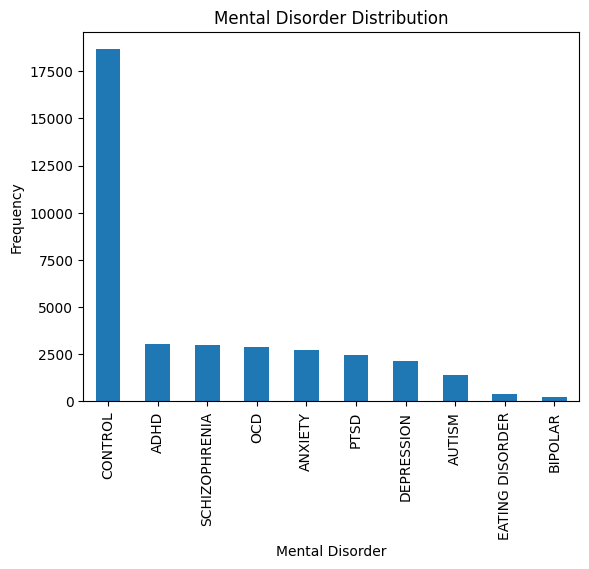

In [17]:
final_data['Disorder'].value_counts().plot(kind="bar")
plt.title("Mental Disorder Distribution")
plt.xlabel("Mental Disorder")
plt.ylabel("Frequency")
plt.show()

In [18]:
data_preprocess = final_data.copy()
data_preprocess["tweet"] = data_preprocess["tweet"].apply(clean_text)
data_preprocess["tweet"] = data_preprocess["tweet"].apply(text_lemmatize)
data_preprocess["tweet"] = data_preprocess["tweet"].apply(remove_stopword)
data_preprocess.to_csv("data_preprocess.csv",index=False)

In [19]:
data_preprocess = data_preprocess[data_preprocess["tweet"]!=""]
data_preprocess["word_count"] = data_preprocess['tweet'].apply(lambda text:len(text.split()))
data_preprocess.head()

,Disorder,tweet,word_count
0,SCHIZOPHRENIA,feelingtake good care growing heart,5
1,ADHD,belly laughing face tear joy,5
2,CONTROL,solid tactic simeone,3
3,CONTROL,partey control middle unmatched,4
4,PTSD,relationship people concealed motif aware othe...,13


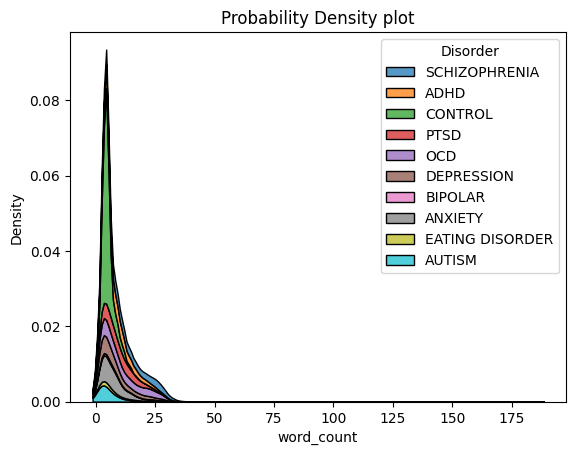

In [20]:
sns.kdeplot(data=data_preprocess,x="word_count",hue="Disorder",multiple="stack")
plt.title("Probability Density plot")
plt.show()

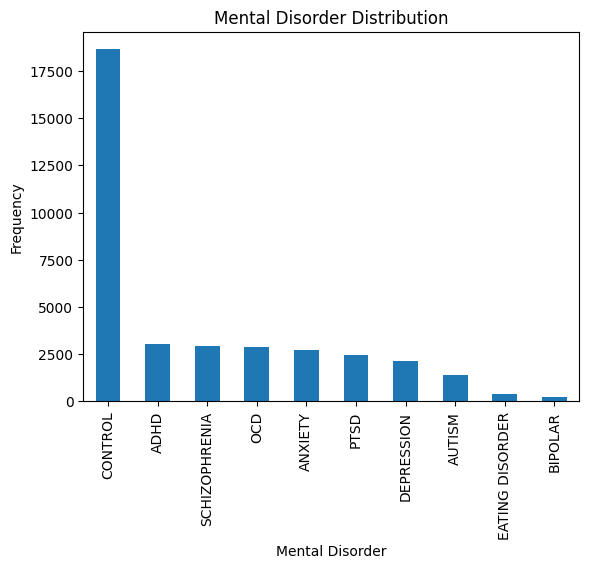

In [21]:
data_preprocess['Disorder'].value_counts().plot(kind="bar")
plt.title("Mental Disorder Distribution")
plt.xlabel("Mental Disorder")
plt.ylabel("Frequency")
plt.show()

# Pipeline

In [22]:
def data_preprocess_pipeline(data_preprocess: pd.DataFrame,
                             ngram_range: list,
                            filename: str,
                            ) -> pd.DataFrame:
    data_preprocess = data_preprocess[~(data_preprocess["tweet"].isnull())]
    data_preprocess = data_preprocess[["class","tweet"]]
    data_preprocess.rename(columns={"class":"Disorder"}, inplace=True)
    data_preprocess["tweet"] = data_preprocess["tweet"].apply(clean_text)
    data_preprocess["tweet"] = data_preprocess["tweet"].apply(text_lemmatize)
    data_preprocess["tweet"] = data_preprocess["tweet"].apply(remove_stopword)
    data_preprocess = data_preprocess[data_preprocess["tweet"]!=""]
    data_preprocess["text_features"] = data_preprocess["tweet"].apply(lambda text: 
                                                                      generate_n_grams(text,n=ngram_range))
    print("saving preprocessed data")
    data_preprocess.to_csv(filename,index=False)
    print("data saved")
    return data_preprocess

# Balanced Dataset training

In [2]:
ngram_range = [1,3]
data_preprocess = data_preprocess_pipeline(pipeline_data,
                                           ngram_range=ngram_range,
                                           filename="balanced_data_preprocess.csv"
                                          )
data_preprocess.head()

In [3]:
data_bin = data_preprocess[["text_features","Disorder"]]
diagnosed_group = data_bin[data_bin["Disorder"]!="CONTROL"]
diagnosed_group["Disorder"] = "DIAGNOSED"
control_group = data_bin[data_bin["Disorder"]=="CONTROL"]
data_bin = pd.concat([diagnosed_group,control_group],axis=0)
encode_target = {"DIAGNOSED":1,
                "CONTROL":0}
data_bin["Disorder"] = data_bin["Disorder"].map(encode_target)
data_bin.head()

In [40]:
data_bin['Disorder'].value_counts()

Disorder
0    18640
1    18232
Name: count, dtype: int64

In [41]:
models_performance = build_models(data_bin,"Disorder",False,"model_performance_balanced_data_UBT.csv")

logistic regression started
Non-Weighted model initialized
Random Forest started
XGBOOST started
SVM rbf started
SVM linear started
SVM poly started
Decision Tree started


In [42]:
models_performance

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,accuracy,models
0,0.959138,0.920831,0.919260,0.959967,0.938776,0.939992,0.939390,Logistic Regression
0,0.963610,0.893909,0.887876,0.965725,0.924194,0.928430,0.926373,Random Forest
0,0.776831,0.937857,0.953326,0.720044,0.856076,0.814642,0.837966,XGBOOST
0,0.959172,0.921558,0.920064,0.959967,0.939211,0.940371,0.939797,SVM_rbf
0,0.965593,0.941208,0.940987,0.965725,0.953131,0.953309,0.953220,SVM_linear
0,0.919431,0.843961,0.832618,0.925418,0.873874,0.882815,0.878508,SVM_poly
0,0.866021,0.860853,0.863466,0.863449,0.864741,0.862149,0.863458,Decision Tree
